In [30]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import re
from datetime import date
import logging
import os

# Cấu hình logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Đường dẫn file
DATA_PATH = r"D:\COMEINN_HOME_PROJECT\DATA\combined_customers.csv"
CLEANED_PATH = DATA_PATH.replace('.csv', '_cleaned.csv')

# === 1. Đọc & Tổng quan dữ liệu ===
try:
    # Tạo bản sao dữ liệu để xử lý, không ảnh hưởng file gốc
    df_customers = pd.read_csv(DATA_PATH, encoding="utf-8-sig", dtype={'IdentityNumber': str, 'PhoneNumber': str}).copy()
    logging.info("Đọc file thành công. Kích thước: %s", df_customers.shape)
except Exception as e:
    logging.error("Lỗi đọc file: %s", str(e))
    raise

print("Số dòng, số cột:", df_customers.shape)
print("Kiểu dữ liệu:\n", df_customers.dtypes)
print(df_customers.info())


2025-06-17 19:51:59,434 - INFO - Đọc file thành công. Kích thước: (238, 13)


Số dòng, số cột: (238, 13)
Kiểu dữ liệu:
 CustomerID                      object
FullName                        object
DateOfBirth                     object
Gender                          object
IdentityNumber                  object
PhoneNumber                     object
Address                         object
Email                           object
VehiclePlateType                object
VehicleType                     object
AppRegistered                   object
TemporaryResidenceRegistered    object
TempResidenceExpiryDate         object
dtype: object
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 238 entries, 0 to 237
Data columns (total 13 columns):
 #   Column                        Non-Null Count  Dtype 
---  ------                        --------------  ----- 
 0   CustomerID                    238 non-null    object
 1   FullName                      238 non-null    object
 2   DateOfBirth                   229 non-null    object
 3   Gender                        237 non

In [31]:
# === 2. Kiểm tra dữ liệu định danh & ngoại lệ ===
if "CustomerID" in df_customers.columns:
    print("Số khách hàng duy nhất:", df_customers['CustomerID'].nunique())
    duplicate_ids = df_customers['CustomerID'].value_counts()[lambda x: x > 1]
    print("Số ID trùng:", len(duplicate_ids))
    print("ID trùng lặp:\n", duplicate_ids)

Số khách hàng duy nhất: 238
Số ID trùng: 0
ID trùng lặp:
 Series([], Name: count, dtype: int64)


In [32]:
# === 3. Xử lý & làm sạch dữ liệu trước ===
def clean_customer_id(series):
    return series.str.strip().str.upper().replace('', np.nan)

def clean_name(series):
    return (series.str.replace(r'^\\d+\\s*', '', regex=True)
                  .str.replace(r'\\(.*?\\)', '', regex=True)
                  .str.replace('\\n', ' ').str.strip()
                  .str.split().str.join(' ').str.title())

def fix_identity_number(series):
    return series.str.replace('.0', '').str.zfill(12)

def clean_phone(series):
    return series.str.replace(r'\\D', '', regex=True).str.zfill(10).replace('0000000000', np.nan)

def clean_app_registered(series):
    # Chuyển tất cả thành chuỗi và xử lý NaN
    series = series.astype(str).str.strip().str.lower()
    series = series.replace('nan', 'Chưa đăng kí')
    return series.apply(lambda x: "Đã đăng kí" if "đã đăng" in x else "Chưa đăng kí")

def clean_temporary_residence(series):
    series = series.astype(str).str.strip().str.lower()

    # Danh sách các từ khóa ánh xạ
    def map_status(x):
        if 'tạm trú' in x:
            return 'Tạm trú'
        elif 'thường trú' in x:
            return 'Thường Trú'
        elif 'lưu trú' in x:
            return 'Lưu Trú'
        elif 'chưa' in x:
            return 'Chưa đăng kí'
        else:
            return 'Chưa xác định'

    return series.apply(map_status)


# Áp dụng làm sạch cơ bản trên bản sao
df_customers['CustomerID'] = clean_customer_id(df_customers['CustomerID'])
df_customers['FullName'] = clean_name(df_customers['FullName'])
df_customers['Gender'] = df_customers['Gender'].str.strip().str.title()
df_customers['IdentityNumber'] = fix_identity_number(df_customers['IdentityNumber'])
df_customers['PhoneNumber'] = clean_phone(df_customers['PhoneNumber'])
df_customers['Email'] = df_customers['Email'].where(df_customers['Email'].str.contains("@", na=False), "Đang cập nhật")
df_customers['VehiclePlateType'] = df_customers['VehiclePlateType'].fillna("Chưa cập nhật")
df_customers['VehicleType'] = df_customers['VehicleType'].fillna("Chưa cập nhật")
df_customers['AppRegistered'] = clean_app_registered(df_customers['AppRegistered'])
df_customers['TemporaryResidenceRegistered'] = clean_temporary_residence(df_customers['TemporaryResidenceRegistered'])
df_customers['TempResidenceExpiryDate'] = pd.to_datetime(df_customers['TempResidenceExpiryDate'], format="%d-%m-%y", errors='coerce')

In [34]:
# === 4. Xử lý DateOfBirth và tính Age ===
df_customers['DateOfBirth'] = pd.to_datetime(df_customers['DateOfBirth'], format="%d-%m-%y", errors='coerce')
df_customers['Age'] = df_customers['DateOfBirth'].apply(lambda x: (date.today().year - x.year) if pd.notnull(x) else None)
if df_customers['Age'].notna().sum() == 0:
    logging.warning("Cột Age hoàn toàn thiếu dữ liệu sau khi xử lý DateOfBirth.")
else:
    outliers = df_customers[(df_customers['Age'] < 0) | (df_customers['Age'] > 120)]['Age']
    if not outliers.empty:
        logging.warning("Phát hiện %d giá trị tuổi bất thường", len(outliers))
        df_customers.loc[outliers.index, 'Age'] = None

In [35]:
# === 5. Gom nhóm tuổi (AgeGroup) ===
def age_group(age):
    if pd.isna(age): return "Không rõ"
    elif age < 18: return "Dưới 18"
    elif age < 25: return "18-24"
    elif age < 35: return "25-34"
    elif age < 50: return "35-49"
    elif age < 65: return "50-64"
    else: return "65+"
df_customers['AgeGroup'] = df_customers['Age'].apply(age_group)

In [36]:
# === 6. Phân phối & phân tích sâu ===
print("Giới tính phân bố:\n", df_customers['Gender'].value_counts())
print("Tỉ lệ đăng ký app:\n", df_customers['AppRegistered'].value_counts(normalize=True).round(2))
if df_customers['Age'].notna().sum() > 0:
    print("Phân bố tuổi theo giới tính:\n", df_customers.groupby('Gender')['Age'].agg(['mean', 'median']).round(1))
else:
    print("Phân bố tuổi theo giới tính: Không có dữ liệu tuổi hợp lệ để tính toán.")
print("Phân bố khách hàng theo nhóm tuổi:\n", df_customers['AgeGroup'].value_counts())

# === 7. Kiểm tra & xử lý dữ liệu thiếu sau khi làm sạch ===
missing_percent = (df_customers.isnull().mean() * 100).round(2)
print("Tỷ lệ thiếu theo cột (%):\n", missing_percent[missing_percent > 0])

Giới tính phân bố:
 Gender
Nam    130
Nữ     107
Name: count, dtype: int64
Tỉ lệ đăng ký app:
 AppRegistered
Chưa đăng kí    0.58
Đã đăng kí      0.42
Name: proportion, dtype: float64
Phân bố tuổi theo giới tính:
         mean  median
Gender              
Nam     25.2    24.0
Nữ      24.4    24.0
Phân bố khách hàng theo nhóm tuổi:
 AgeGroup
18-24       118
25-34        86
35-49        17
Không rõ      9
Dưới 18       6
50-64         2
Name: count, dtype: int64
Tỷ lệ thiếu theo cột (%):
 DateOfBirth                 3.78
Gender                      0.42
IdentityNumber              3.78
PhoneNumber                 6.30
Address                     7.98
TempResidenceExpiryDate    49.16
Age                         3.78
dtype: float64


# === 8. Trực quan hóa nâng cao ===


2025-06-17 19:52:31,989 - WARNING - No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


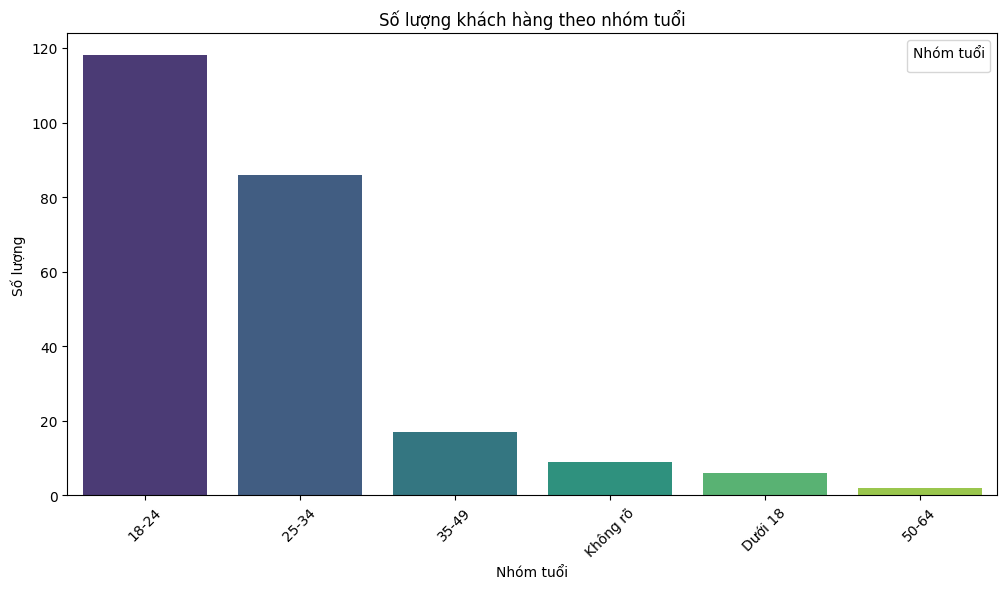

In [37]:
# Biểu đồ cột cho AgeGroup
if len(df_customers['AgeGroup'].value_counts()) > 1:
    plt.figure(figsize=(12, 6))
    sns.countplot(x='AgeGroup', data=df_customers, hue='AgeGroup', palette='viridis')
    plt.title('Số lượng khách hàng theo nhóm tuổi')
    plt.xlabel('Nhóm tuổi')
    plt.ylabel('Số lượng')
    plt.xticks(rotation=45)
    plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{int(x):,}'))
    plt.legend(title='Nhóm tuổi')
    plt.show()
else:
    print("Cảnh báo: Chỉ có một nhóm tuổi duy nhất ('Không rõ'), biểu đồ không thể hiển thị phân phối.")


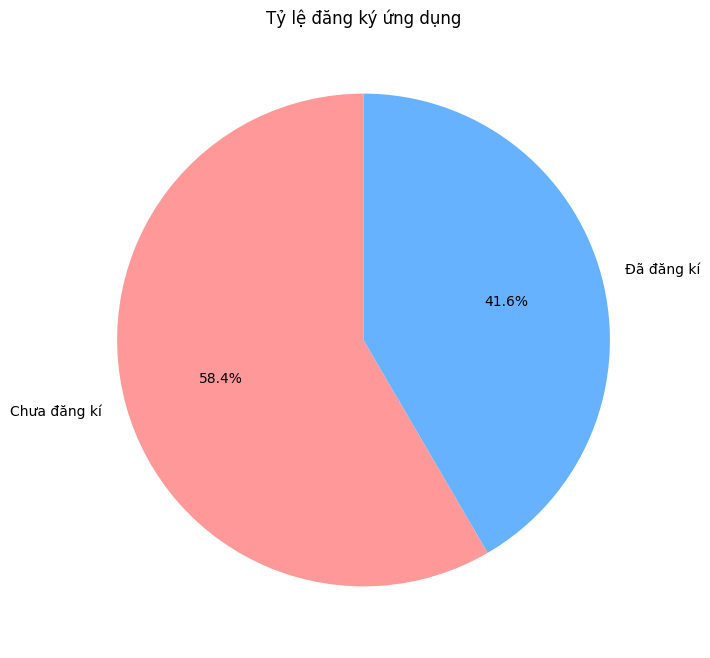

In [38]:
# Biểu đồ pie cho AppRegistered
plt.figure(figsize=(8, 8))
df_customers['AppRegistered'].value_counts().plot.pie(autopct='%1.1f%%', startangle=90, colors=['#FF9999', '#66B2FF'])
plt.title('Tỷ lệ đăng ký ứng dụng')
plt.ylabel('')
plt.show()

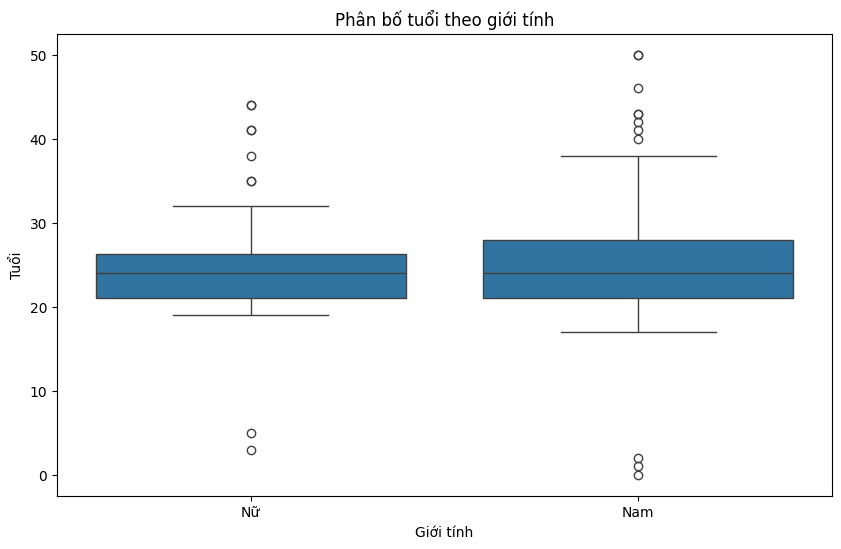

In [16]:
# Biểu đồ hộp (Box Plot) cho Age theo Gender (nếu có dữ liệu tuổi)
if df_customers['Age'].notna().sum() > 0:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='Gender', y='Age', data=df_customers.dropna(subset=['Age']))
    plt.title('Phân bố tuổi theo giới tính')
    plt.xlabel('Giới tính')
    plt.ylabel('Tuổi')
    plt.show()
else:
    print("Cảnh báo: Không có dữ liệu tuổi hợp lệ để vẽ Box Plot.")


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_14996\952884482.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['ExpiryMonth'] = df_temp['TempResidenceExpiryDate'].dt.to_period('M')


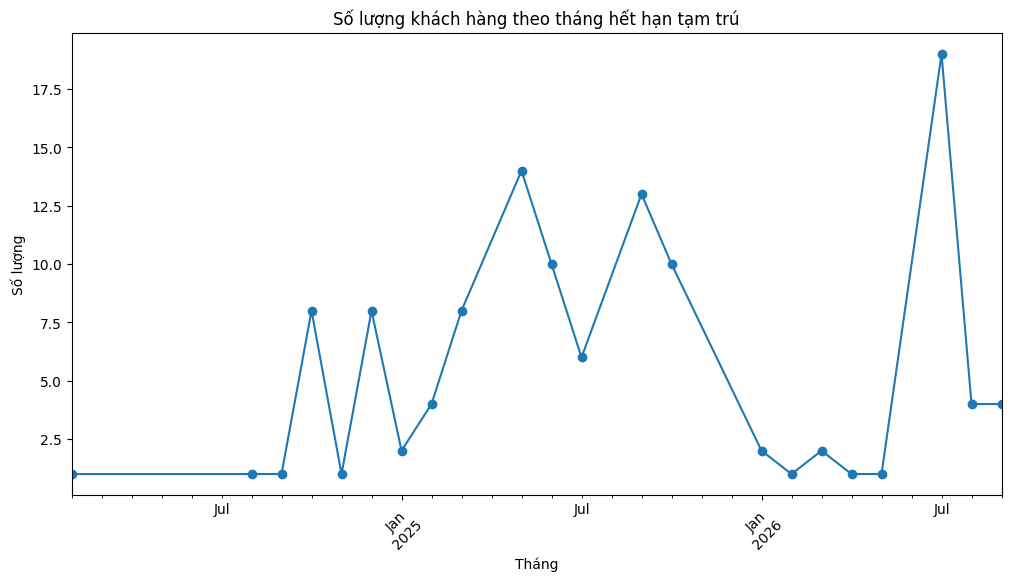

In [17]:
# Biểu đồ đường (Line Chart) cho TempResidenceExpiryDate (nếu có dữ liệu)
if df_customers['TempResidenceExpiryDate'].notna().sum() > 0:
    df_temp = df_customers.dropna(subset=['TempResidenceExpiryDate'])
    df_temp['ExpiryMonth'] = df_temp['TempResidenceExpiryDate'].dt.to_period('M')
    expiry_counts = df_temp['ExpiryMonth'].value_counts().sort_index()
    plt.figure(figsize=(12, 6))
    expiry_counts.plot(kind='line', marker='o')
    plt.title('Số lượng khách hàng theo tháng hết hạn tạm trú')
    plt.xlabel('Tháng')
    plt.ylabel('Số lượng')
    plt.xticks(rotation=45)
    plt.show()
else:
    print("Cảnh báo: Không có dữ liệu TempResidenceExpiryDate hợp lệ để vẽ Line Chart.")



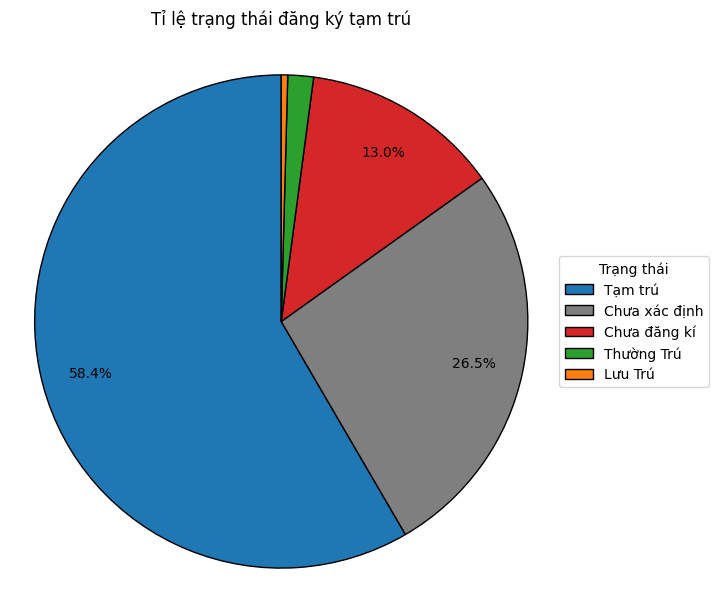

In [39]:
counts = df_customers['TemporaryResidenceRegistered'].value_counts()

colors = {
    'Thường Trú': '#2ca02c',
    'Tạm trú': '#1f77b4',
    'Lưu Trú': '#ff7f0e',
    'Chưa đăng kí': '#d62728'
}

color_list = [colors.get(x, '#7f7f7f') for x in counts.index]

plt.figure(figsize=(7, 7))

def autopct_func(pct):
    return ('%1.1f%%' % pct) if pct > 5 else ''

wedges, texts, autotexts = plt.pie(
    counts,
    autopct=autopct_func,
    startangle=90,
    wedgeprops={'edgecolor': 'black'},
    pctdistance=0.8,
    labels=None,
    colors=color_list
)

plt.title('Tỉ lệ trạng thái đăng ký tạm trú', pad=20)

plt.axis('equal')

plt.legend(
    wedges, counts.index,
    title="Trạng thái",
    loc="center left",
    bbox_to_anchor=(1, 0, 0.5, 1),
    fontsize=10
)

In [40]:
# === 9. Xuất dữ liệu & kiểm tra ===
# Chỉ xuất file mới, không ghi đè file gốc
if not os.path.exists(CLEANED_PATH):
    df_export = df_customers.copy()
    df_export['TempResidenceExpiryDate'] = df_export['TempResidenceExpiryDate'].apply(lambda x: x.strftime('%Y-%m-%d') if pd.notna(x) else "Đang cập nhật")
    df_export.to_csv(CLEANED_PATH, index=False, encoding='utf-8-sig')
    logging.info("Xuất file đã làm sạch thành công: %s", CLEANED_PATH)
else:
    logging.warning("File cleaned đã tồn tại. Không ghi đè để bảo vệ dữ liệu gốc.")

print("\nKiểu dữ liệu sau khi xử lý:\n", df_customers.dtypes)
print("Tỷ lệ thiếu sau xử lý (%):\n", (df_customers.isnull().mean() * 100).round(2)[(df_customers.isnull().mean() * 100) > 0])

2025-06-17 19:52:55,600 - WARNING - File cleaned đã tồn tại. Không ghi đè để bảo vệ dữ liệu gốc.



Kiểu dữ liệu sau khi xử lý:
 CustomerID                              object
FullName                                object
DateOfBirth                     datetime64[ns]
Gender                                  object
IdentityNumber                          object
PhoneNumber                             object
Address                                 object
Email                                   object
VehiclePlateType                        object
VehicleType                             object
AppRegistered                           object
TemporaryResidenceRegistered            object
TempResidenceExpiryDate         datetime64[ns]
Age                                    float64
AgeGroup                                object
dtype: object
Tỷ lệ thiếu sau xử lý (%):
 DateOfBirth                 3.78
Gender                      0.42
IdentityNumber              3.78
PhoneNumber                 6.30
Address                     7.98
TempResidenceExpiryDate    49.16
Age                      

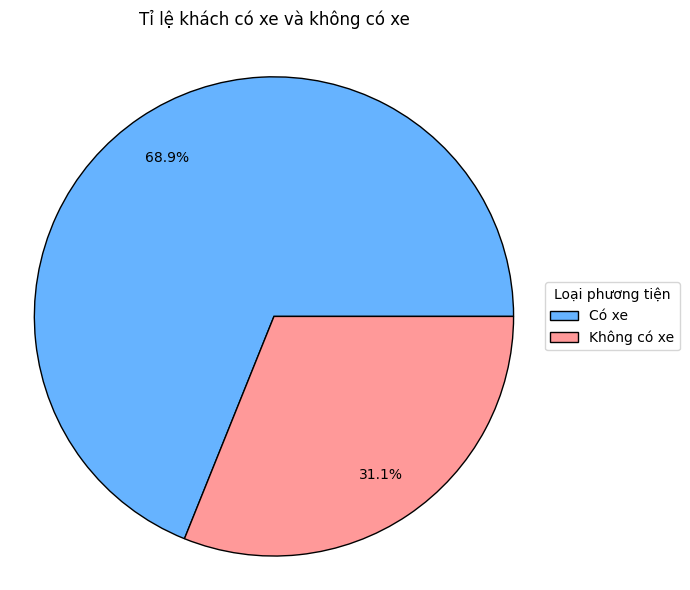

In [42]:
# Hàm phân loại tình trạng xe
def classify_vehicle(val):
    if pd.isna(val) or str(val).strip().lower() in ['chưa cập nhật', 'không có xe', 'ko có xe', '']: 
        return 'Không có xe'
    else:
        return 'Có xe'

# Phân loại
df_customers['VehicleStatus'] = df_customers['VehiclePlateType'].apply(classify_vehicle)
vehicle_counts = df_customers['VehicleStatus'].value_counts()

# Vẽ pie chart
colors = ['#66b3ff', '#ff9999']
fig, ax = plt.subplots(figsize=(7, 6))
wedges, texts, autotexts = ax.pie(
    vehicle_counts,
    labels=None,  
    autopct='%1.1f%%',  
    colors=colors,
    wedgeprops={'edgecolor': 'black'},
    pctdistance=0.8
)

# Chỉnh font cho phần trăm
for autotext in autotexts:
    autotext.set_fontsize(10)
    autotext.set_color('black')

# Tiêu đề
plt.title("Tỉ lệ khách có xe và không có xe", pad=20)

# Giữ tỉ lệ hình tròn
ax.axis('equal')

# Chú thích nằm ngoài bên phải
ax.legend(wedges, vehicle_counts.index, title="Loại phương tiện", loc="center left", bbox_to_anchor=(1, 0.5))

plt.tight_layout()
plt.show()


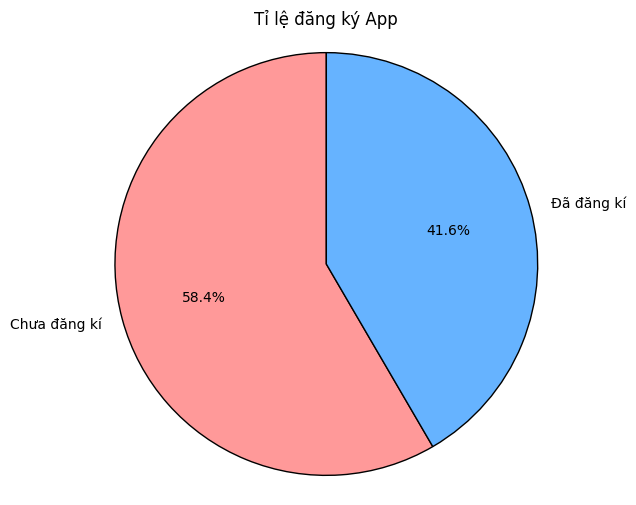

In [43]:
# Đếm số lượng từng loại đăng ký
counts = df_customers['AppRegistered'].value_counts()

# Vẽ biểu đồ tròn
plt.figure(figsize=(6, 6))
plt.pie(
    counts, 
    labels=counts.index, 
    autopct='%1.1f%%', 
    startangle=90, 
    colors=['#ff9999', '#66b3ff'],  # Tùy chỉnh màu sắc
    wedgeprops={'edgecolor': 'black'}
)
plt.title('Tỉ lệ đăng ký App')
plt.axis('equal')  # Giữ hình tròn
plt.show()


In [45]:
df_branch = pd.read_csv(r"D:\COMEINN_HOME_PROJECT\DATA\BRANCH.csv", encoding="utf-8-sig")
print("Số dòng và cột của beds.csv:", df_branch.shape)
df_branch.info()

Số dòng và cột của beds.csv: (5, 3)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   BranchID  5 non-null      object
 1   Name      5 non-null      object
 2   Address   5 non-null      object
dtypes: object(3)
memory usage: 252.0+ bytes


In [ ]:
df_room = pd.read_csv(r"D:\COMEINN_HOME_PROJECT\DATA\ROOM.csv", encoding="utf-8-sig")
print("Số dòng và cột của beds.csv:", df_room.shape)
df_room.info()
df_room["BedCount"] = df_room["BedCount"].fillna(1)
df_room["RoomGender"] = df_room["RoomGender"].fillna("Nam/Nữ")
df_room.isnull().sum()
df_room.to_csv(r"D:\COMEINN_HOME_PROJECT\DATA\ROOMS_CLEANED.csv", index=False, encoding='utf-8-sig')


Số dòng và cột của beds.csv: (36, 8)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36 entries, 0 to 35
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   RoomID      36 non-null     object 
 1   BranchID    36 non-null     object 
 2   RoomNumber  36 non-null     int64  
 3   BedCount    23 non-null     float64
 4   Area        36 non-null     int64  
 5   RoomType    36 non-null     object 
 6   RoomGender  24 non-null     object 
 7   Amenities   36 non-null     object 
dtypes: float64(1), int64(2), object(5)
memory usage: 2.4+ KB


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_14996\1034938418.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=room_counts, x='BranchID', y='RoomCount', palette='viridis')


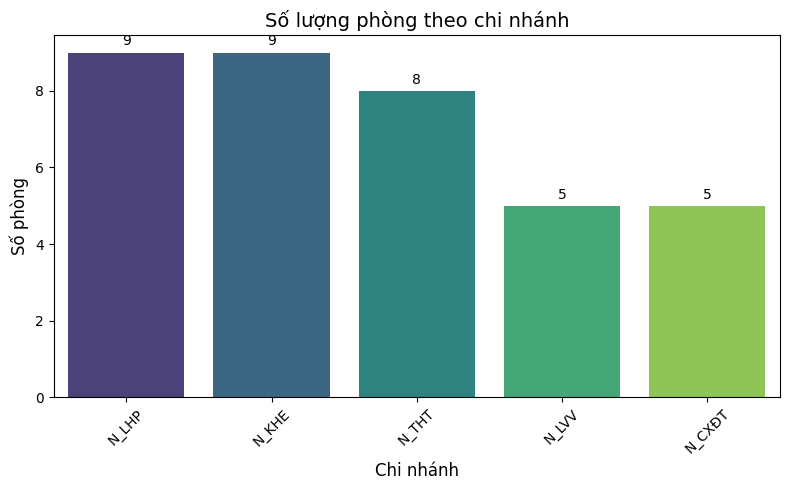

In [53]:
# Đọc dữ liệu
df_room = pd.read_csv(r"D:\COMEINN_HOME_PROJECT\DATA\ROOMS_CLEANED.csv", encoding='utf-8-sig')

# Đếm số phòng theo chi nhánh
room_counts = df_room['BranchID'].value_counts().reset_index()
room_counts.columns = ['BranchID', 'RoomCount']

# Vẽ biểu đồ cột
plt.figure(figsize=(8, 5))
ax = sns.barplot(data=room_counts, x='BranchID', y='RoomCount', palette='viridis')

# Thêm số phòng trên đầu mỗi cột
for i in ax.containers:
    ax.bar_label(i, fmt='%d', label_type='edge', padding=3, fontsize=10)

# Trang trí biểu đồ
plt.title("Số lượng phòng theo chi nhánh", fontsize=14)
plt.xlabel("Chi nhánh", fontsize=12)
plt.ylabel("Số phòng", fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_14996\1037060355.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=room_type_counts.index, y=room_type_counts.values, palette='Set2')
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_14996\1037060355.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=room_gender_counts.index, y=room_gender_counts.values, palette='Set3')


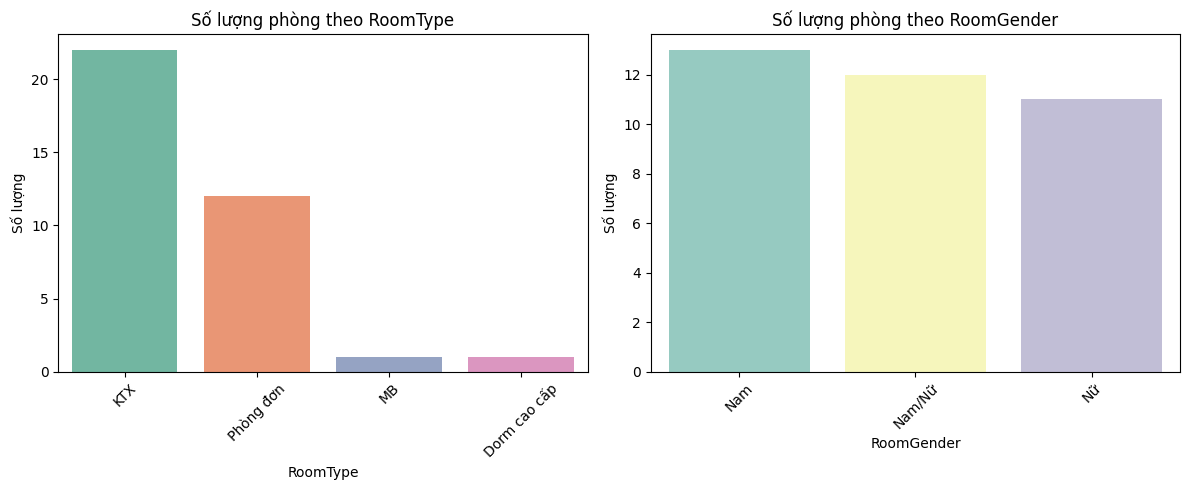

In [54]:
# Đọc dữ liệu
df_room = pd.read_csv(r"D:\COMEINN_HOME_PROJECT\DATA\ROOMS_CLEANED.csv", encoding='utf-8-sig')

# Tạo figure với 2 biểu đồ
plt.figure(figsize=(12, 5))

# --- Biểu đồ RoomType ---
plt.subplot(1, 2, 1)
room_type_counts = df_room['RoomType'].value_counts()
sns.barplot(x=room_type_counts.index, y=room_type_counts.values, palette='Set2')
plt.title("Số lượng phòng theo RoomType")
plt.xlabel("RoomType")
plt.ylabel("Số lượng")
plt.xticks(rotation=45)

# --- Biểu đồ RoomGender ---
plt.subplot(1, 2, 2)
room_gender_counts = df_room['RoomGender'].value_counts()
sns.barplot(x=room_gender_counts.index, y=room_gender_counts.values, palette='Set3')
plt.title("Số lượng phòng theo RoomGender")
plt.xlabel("RoomGender")
plt.ylabel("Số lượng")
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

Số dòng và cột của beds.csv: (141, 4)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 141 entries, 0 to 140
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   BedID     141 non-null    object
 1   RoomID    141 non-null    object
 2   Position  120 non-null    object
 3   BedNo     124 non-null    object
dtypes: object(4)
memory usage: 4.5+ KB
Phân bố theo Position:
 Position
D    63
T    57
Name: count, dtype: int64


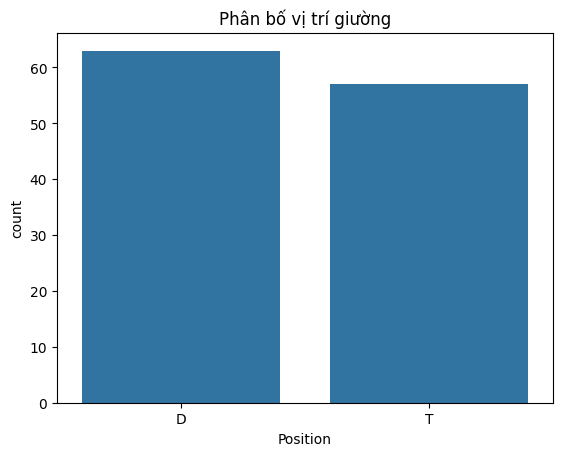

    RoomID  SoGiuong
0   CXDT01         1
1   CXDT02         6
2   CXDT03         1
3   CXDT04         4
4   CXDT05         8
5    KHE01         1
6    KHE02         1
7    KHE03         1
8    KHE04         1
9    KHE05         1
10   KHE06         1
11   KHE07         4
12   KHE08         1
13   KHEMB         1
14   LHP00         1
15   LHP01         4
16   LHP02         1
17   LHP03         4
18   LHP04         4
19   LHP05         4
20   LHP06         4
21   LHP07         4
22   LHP08         4
23   LVV01         8
24   LVV02         8
25   LVV03         8
26   LVV04         8
27   LVV05         1
28   THT00         4
29   THT01         8
30   THT02         8
31   THT03         4
32   THT04         6
33   THT05         8
34   THT06         4
35   THT07         4


In [58]:
df_beds = pd.read_csv(r"D:\COMEINN_HOME_PROJECT\DATA\BEDS.csv", encoding="utf-8-sig")
print("Số dòng và cột của beds.csv:", df_beds.shape)
df_beds.info()  
df_beds.columns = df_beds.columns.str.strip().str.replace('\t', '', regex=True)
df_beds.isnull().sum()
print("Phân bố theo Position:\n", df_beds['Position'].value_counts())
sns.countplot(data=df_beds, x='Position', order=df_beds['Position'].value_counts().index)
plt.title("Phân bố vị trí giường")
plt.show()
bed_count_per_room = df_beds.groupby('RoomID')['BedID'].count().reset_index()
bed_count_per_room.columns = ['RoomID', 'SoGiuong']

# Xem kết quả
print(bed_count_per_room)

In [59]:
df_price = pd.read_csv(r"D:\COMEINN_HOME_PROJECT\DATA\PRICE.csv", encoding="utf-8-sig")
print("Số dòng và cột của beds.csv:", df_price.shape)
df_price.rename(columns={
    "ElectricityPrice": "ElectricityPrice_per_kWh",
    "WaterPrice": "WaterPrice_per_person",
    "ParkingFee": "ParkingFee_per_vehicle"
}, inplace=True)
def clean_price(val):
    if pd.isna(val):
        return None
    val = str(val)
    val = val.replace(",", "")  # bỏ dấu phẩy nếu có
    val = ''.join(c for c in val if c.isdigit())  # lấy số
    return int(val) if val else None
# Áp dụng hàm cho các cột
df_price["ElectricityPrice_per_kWh"] = df_price["ElectricityPrice_per_kWh"].apply(clean_price)
df_price["WaterPrice_per_person"] = df_price["WaterPrice_per_person"].apply(clean_price)
df_price["ParkingFee_per_vehicle"] = df_price["ParkingFee_per_vehicle"].apply(clean_price)
df_price.info()
df_price.to_csv(r"D:\COMEINN_HOME_PROJECT\DATA\PRICE_CLEANED.csv", index=False, encoding='utf-8-sig')



Số dòng và cột của beds.csv: (141, 6)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 141 entries, 0 to 140
Data columns (total 6 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   PriceID                   141 non-null    object 
 1   BedID                     141 non-null    object 
 2   Price                     141 non-null    int64  
 3   ElectricityPrice_per_kWh  11 non-null     float64
 4   WaterPrice_per_person     11 non-null     float64
 5   ParkingFee_per_vehicle    47 non-null     float64
dtypes: float64(3), int64(1), object(2)
memory usage: 6.7+ KB


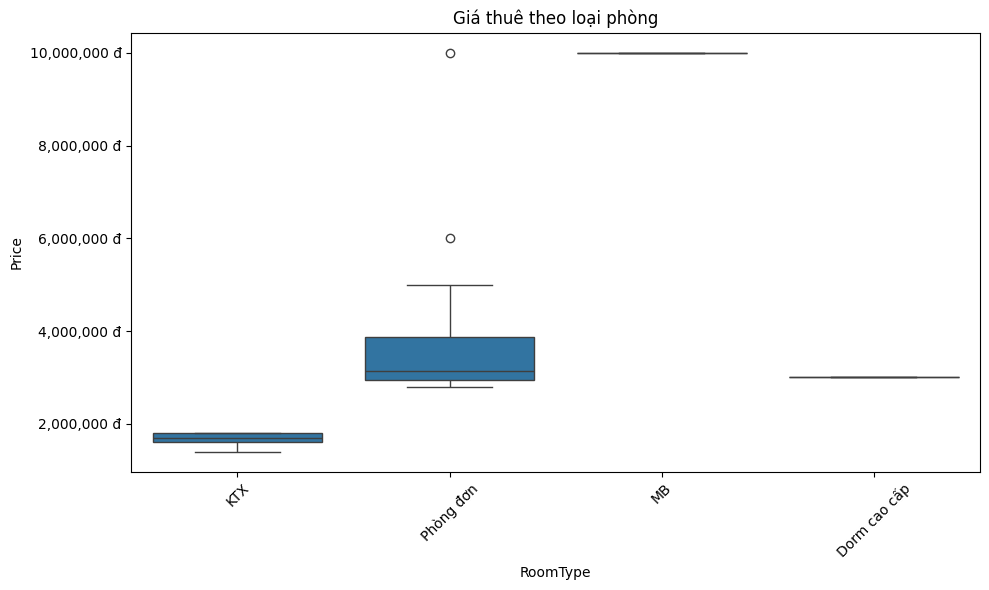

In [60]:

df_room_slim = df_room [['RoomID','RoomType']]
df_beds_slim = df_beds [['BedID','RoomID']]
df_price_slim = df_price[['BedID', 'Price']]  
# Merge beds với room để lấy RoomType
df_bed_room = df_beds_slim.merge(df_room_slim, on='RoomID', how='left')

# Merge tiếp với price để có Price
df_price_room = df_bed_room.merge(df_price_slim, on='BedID', how='left')

# Vẽ biểu đồ Boxplot giá theo loại phòng
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

plt.figure(figsize=(10, 6))
sns.boxplot(data=df_price_room, x='RoomType', y='Price')
plt.title('Giá thuê theo loại phòng')
plt.xticks(rotation=45)

# Hiển thị đầy đủ số tiền với dấu phẩy ngăn cách hàng nghìn
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{int(x):,} đ'))

plt.tight_layout()
plt.show()



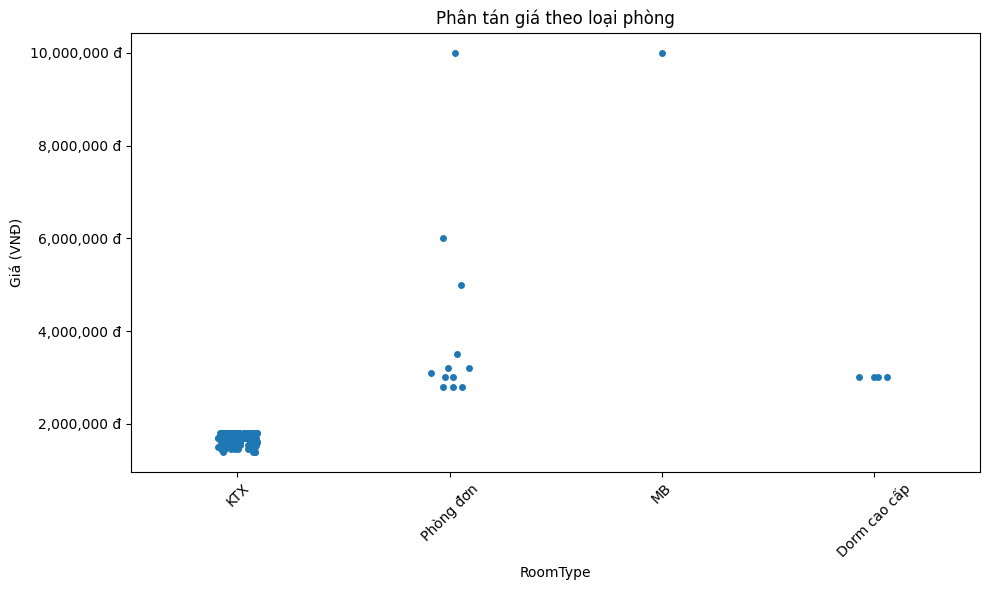

In [61]:
plt.figure(figsize=(10, 6))
sns.stripplot(data=df_price_room, x='RoomType', y='Price', jitter=True)
plt.title('Phân tán giá theo loại phòng')
plt.xticks(rotation=45)
plt.ylabel('Giá (VNĐ)')
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{int(x):,} đ'))
plt.tight_layout()
plt.show()


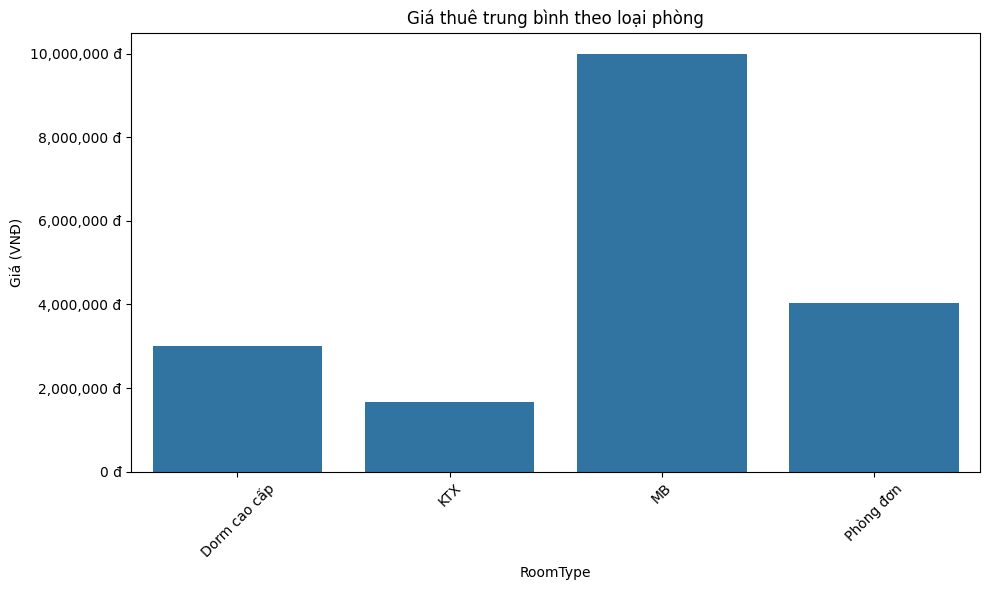

In [25]:

# Tính giá trung bình theo loại phòng
avg_price_by_type = df_price_room.groupby('RoomType')['Price'].mean().reset_index()

# Vẽ biểu đồ cột
plt.figure(figsize=(10, 6))
sns.barplot(data=avg_price_by_type, x='RoomType', y='Price')
plt.title('Giá thuê trung bình theo loại phòng')
plt.xticks(rotation=45)
plt.ylabel('Giá (VNĐ)')

# Format số tiền
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{int(x):,} đ'))

plt.tight_layout()
plt.show()

In [62]:

# Đọc file
df_contracts = pd.read_csv(r"D:\COMEINN_HOME_PROJECT\DATA\CONTRACTS.csv", encoding="utf-8-sig")
print("Số dòng và cột của contracts.csv:", df_contracts.shape)

# Chuyển cột ngày từ định dạng dd-mm-yy sang datetime ISO (yyyy-mm-dd)
for col in ["StartDate", "EndDate", "CheckoutDate"]:
    df_contracts[col] = pd.to_datetime(df_contracts[col], format="%d-%m-%y", errors="coerce")

# Ngày tham chiếu
current_date = pd.to_datetime('2025-03-31')

# Hàm phân loại trạng thái hợp đồng
def classify_contract(row):
    start = row['StartDate']
    end = row['EndDate']
    checkout = row['CheckoutDate']
    if pd.isna(checkout):
        if current_date > end:
            return 'Overdue'
        elif current_date < start:
            return 'Not started'
        else:
            return 'Ongoing'
    else:
        if checkout < end:
            return 'Terminated Early'
        elif checkout == end:
            return 'Completed'
        else:
            return 'Terminated Late'

# Gán trạng thái
df_contracts['Status'] = df_contracts.apply(classify_contract, axis=1)

# Sắp xếp theo khách hàng và ngày bắt đầu
df_contracts = df_contracts.sort_values(['CustomerID', 'StartDate'])

# Xác định hợp đồng gia hạn
next_start = df_contracts.groupby('CustomerID')['StartDate'].shift(-1)
gap_days = (next_start - df_contracts['EndDate']).dt.days
df_contracts['IsRenewal'] = gap_days.apply(lambda x: pd.notna(x) and x <= 30)

# Tính độ dài hợp đồng
df_contracts['ContractLength'] = (df_contracts['EndDate'] - df_contracts['StartDate']).dt.days

# Chuẩn hóa mã khách hàng
df_contracts['CustomerID'] = df_contracts['CustomerID'].astype(str).str.strip().str.upper()

# Cài đặt hiển thị đầy đủ
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

# Hiển thị kiểm tra
print(df_contracts[['ID', 'CustomerID', 'StartDate', 'EndDate', 'CheckoutDate', 'Status', 'IsRenewal', 'ContractLength']])

# ✅ Ghi file với định dạng ngày ISO
df_contracts.to_csv(
    r"D:\COMEINN_HOME_PROJECT\DATA\CONTRACTS_CLEANED.csv",
    index=False,
    encoding='utf-8-sig',
    date_format='%Y-%m-%d'  # Dùng đúng định dạng ISO
)
df_contracts.dtypes

Số dòng và cột của contracts.csv: (297, 6)
         ID CustomerID  StartDate    EndDate CheckoutDate            Status  \
289  HD1292   KH012997 2024-06-15 2024-11-15   2024-11-15         Completed   
124  HD1124   KH021085 2024-07-01 2024-09-01          NaT           Overdue   
139  HD1139   KH022287 2023-05-31 2024-05-31          NaT           Overdue   
140  HD1140   KH022287 2024-06-01 2024-12-01          NaT           Overdue   
141  HD1141   KH022287 2024-12-02 2025-12-02          NaT           Ongoing   
224  HD1226   KH022884 2024-02-20 2025-02-20          NaT           Overdue   
263  HD1266   KH022885 2024-03-01 2024-06-01   2024-06-01         Completed   
244  HD1247   KH022886 2024-03-01 2024-06-01   2024-06-01         Completed   
232  HD1234   KH022891 2024-09-01 2024-12-01          NaT           Overdue   
234  HD1236   KH022891 2024-12-01 2025-12-01          NaT           Ongoing   
233  HD1235   KH022892 2024-09-01 2024-12-01          NaT           Overdue   
235  HD12

ID                        object
CustomerID                object
BedID                     object
StartDate         datetime64[ns]
EndDate           datetime64[ns]
CheckoutDate      datetime64[ns]
Status                    object
IsRenewal                   bool
ContractLength             int64
dtype: object

In [63]:
# Thống kê cột ContracLength
df_contracts["ContractLength"].describe()

count     297.000000
mean      214.622896
std       142.027997
min        31.000000
25%       122.000000
50%       183.000000
75%       365.000000
max      1827.000000
Name: ContractLength, dtype: float64

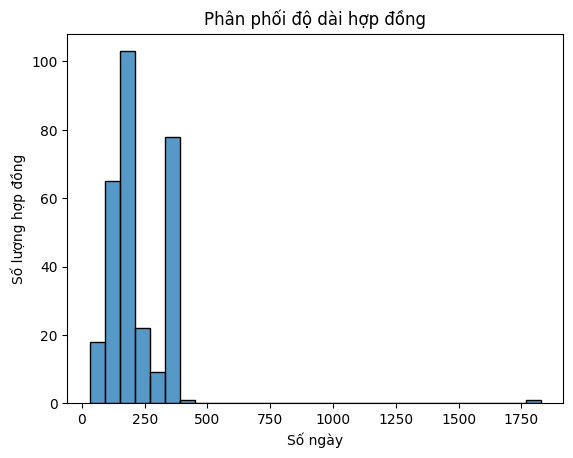

In [32]:
# Phân phối độ dài hợp đồng
sns.histplot(df_contracts['ContractLength'], bins=30)
plt.title('Phân phối độ dài hợp đồng')
plt.xlabel('Số ngày')
plt.ylabel('Số lượng hợp đồng')
plt.show()

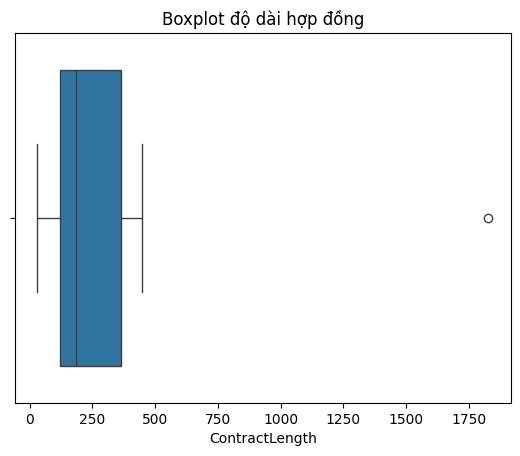

In [64]:
# Boxplot để phát hiện hợp đồng bất thường
sns.boxplot(x=df_contracts['ContractLength'])
plt.title('Boxplot độ dài hợp đồng')
plt.show()

Status
Overdue             96
Ongoing             81
Completed           61
Terminated Early    49
Terminated Late      9
Not started          1
Name: count, dtype: int64


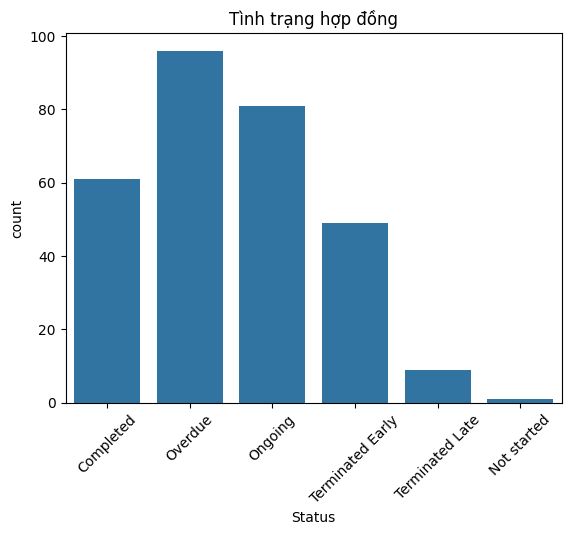

In [65]:
# Số lượng hợp đồng theo trạng thái
print(df_contracts['Status'].value_counts())

# Tổng hợp theo trạng thái
sns.countplot(data=df_contracts, x='Status')
plt.title('Tình trạng hợp đồng')
plt.xticks(rotation=45)
plt.show()

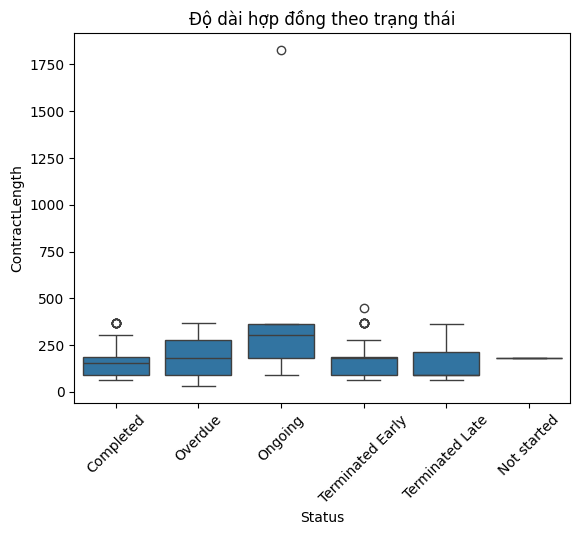

In [35]:
sns.boxplot(data=df_contracts, x='Status', y='ContractLength')
plt.xticks(rotation=45)
plt.title('Độ dài hợp đồng theo trạng thái')
plt.show()


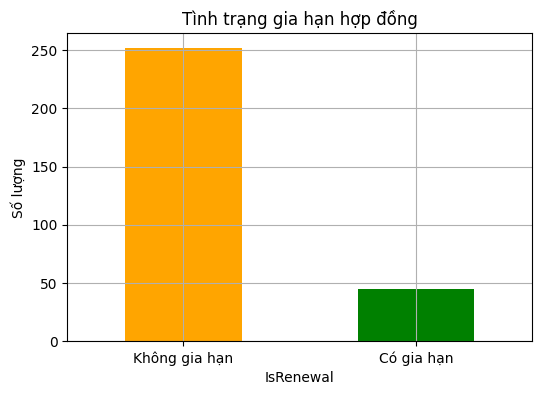

In [66]:
renewal_counts = df_contracts['IsRenewal'].value_counts()
plt.figure(figsize=(6, 4))
renewal_counts.plot(kind='bar', color=['orange', 'green'])
plt.title('Tình trạng gia hạn hợp đồng')
plt.xticks(ticks=[0, 1], labels=['Không gia hạn', 'Có gia hạn'], rotation=0)
plt.ylabel('Số lượng')
plt.grid(True)
plt.show()


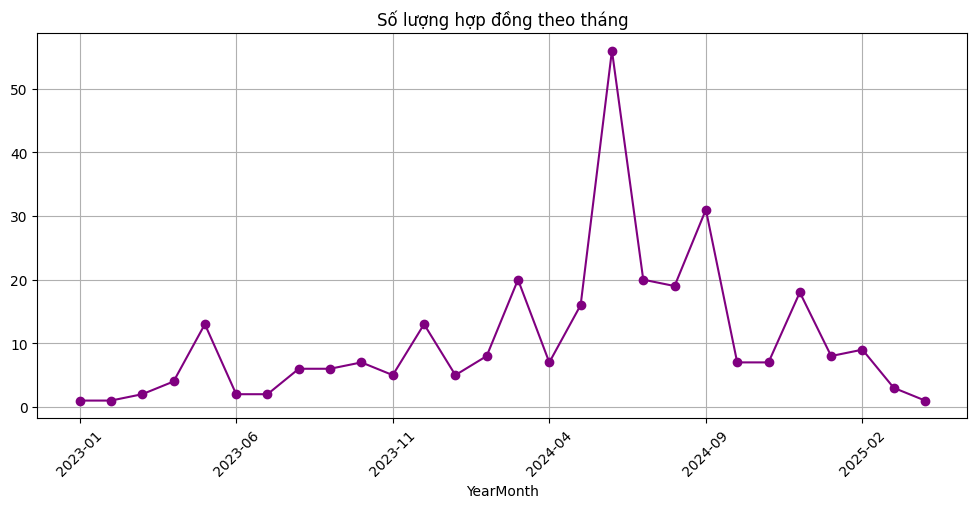

In [67]:
df_contracts['YearMonth'] = df_contracts['StartDate'].dt.to_period('M').astype(str)
monthly_counts = df_contracts.groupby('YearMonth').size()
plt.figure(figsize=(12, 5))
monthly_counts.plot(kind='line', marker='o', color='purple')
plt.title('Số lượng hợp đồng theo tháng')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()



In [68]:
# Tỷ lệ hợp đồng quá hạn
overdue_ratio = (df_contracts['Status'] == 'Overdue').mean()
print(f"Tỷ lệ hợp đồng quá hạn: {overdue_ratio:.2%}")

# Tỷ lệ gia hạn
renewal_rate = df_contracts['IsRenewal'].mean()
print(f"Tỷ lệ hợp đồng được gia hạn: {renewal_rate:.2%}")

Tỷ lệ hợp đồng quá hạn: 32.32%
Tỷ lệ hợp đồng được gia hạn: 15.15%


In [71]:
contract_counts = df_contracts.groupby('CustomerID').size().sort_values(ascending=False)
print(contract_counts.head(10))
df_contracts['ContractLength'] = (df_contracts['EndDate'] - df_contracts['StartDate']).dt.days
customer_days = df_contracts.groupby('CustomerID')['ContractLength'].sum().sort_values(ascending=False)
print(customer_days.head(10))


CustomerID
KH022287    3
KH044864    2
KH023101    2
KH044863    2
KH089012    2
KH023089    2
KH041420    2
KH089015    2
KH053005    2
KH023094    2
dtype: int64
CustomerID
KH023773    1827
KH022287     914
KH023198     731
KH023098     731
KH023215     731
KH023786     731
KH037361     731
KH041420     731
KH055368     731
KH022969     731
Name: ContractLength, dtype: int64


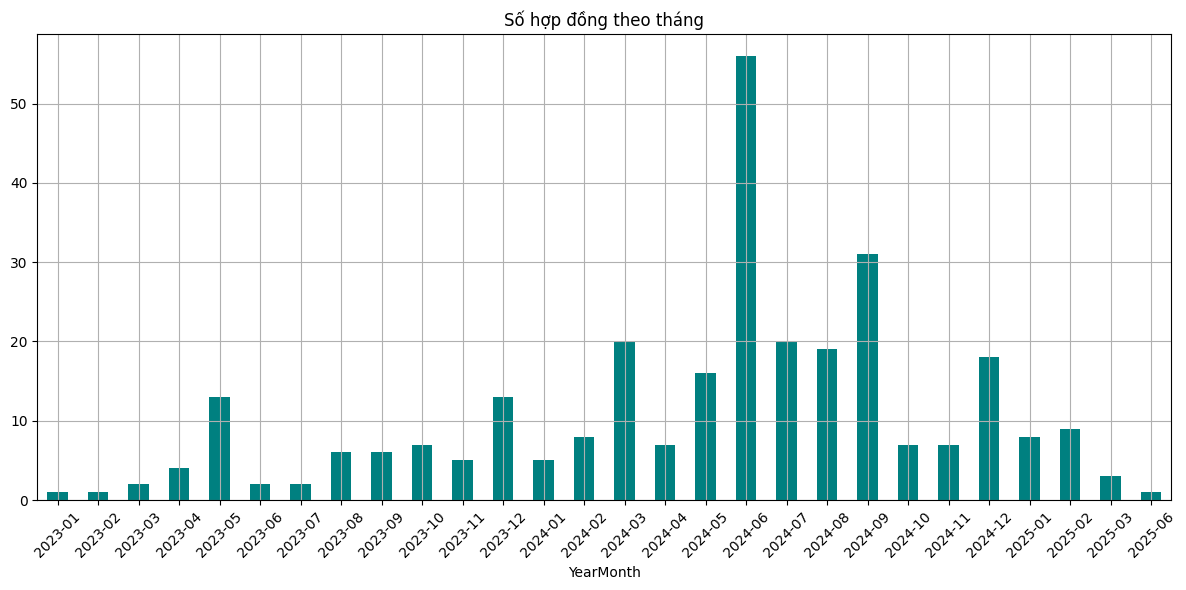

In [72]:
df_contracts['YearMonth'] = df_contracts['StartDate'].dt.to_period('M').astype(str)
monthly_counts = df_contracts.groupby('YearMonth').size()

monthly_counts.plot(kind='bar', figsize=(12, 6), color='teal')
plt.title("Số hợp đồng theo tháng")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


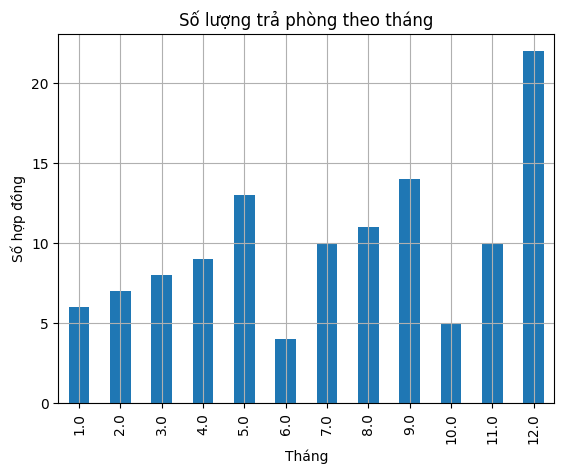

In [73]:
df_contracts['CheckoutMonth'] = df_contracts['CheckoutDate'].dt.month
df_contracts['CheckoutMonth'].value_counts().sort_index().plot(kind='bar')
plt.title("Số lượng trả phòng theo tháng")
plt.xlabel("Tháng")
plt.ylabel("Số hợp đồng")
plt.grid(True)
plt.show()


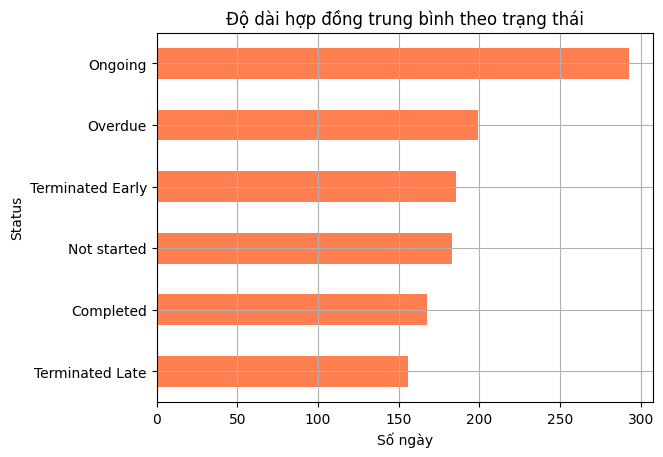

In [74]:
df_contracts.groupby('Status')['ContractLength'].mean().sort_values().plot(kind='barh', color='coral')
plt.title("Độ dài hợp đồng trung bình theo trạng thái")
plt.xlabel("Số ngày")
plt.grid(True)
plt.show()


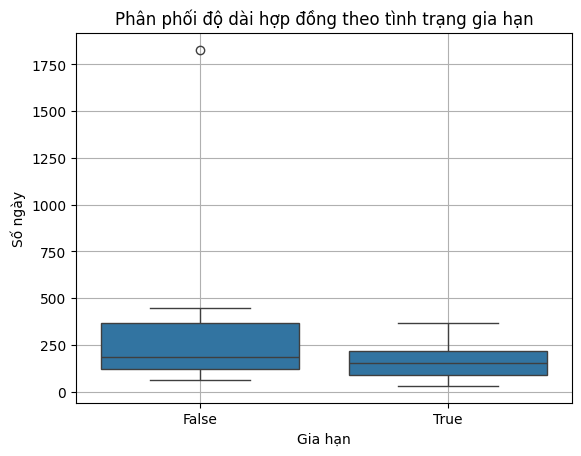

In [75]:
sns.boxplot(x='IsRenewal', y='ContractLength', data=df_contracts)
plt.title("Phân phối độ dài hợp đồng theo tình trạng gia hạn")
plt.xlabel("Gia hạn")
plt.ylabel("Số ngày")
plt.grid(True)
plt.show()

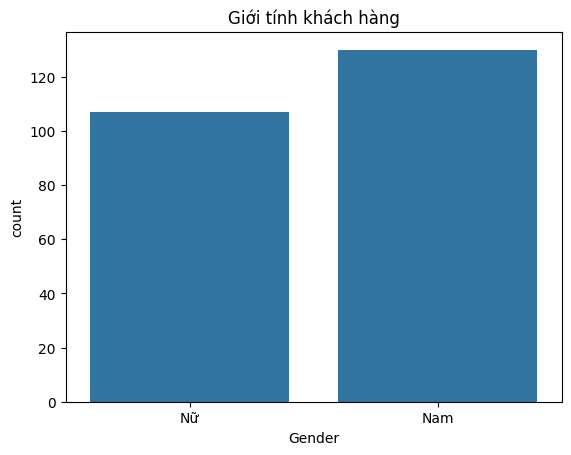

In [76]:
# Phân loại khách theo giới tính
sns.countplot(data=df_customers, x='Gender')
plt.title('Giới tính khách hàng')
plt.show()



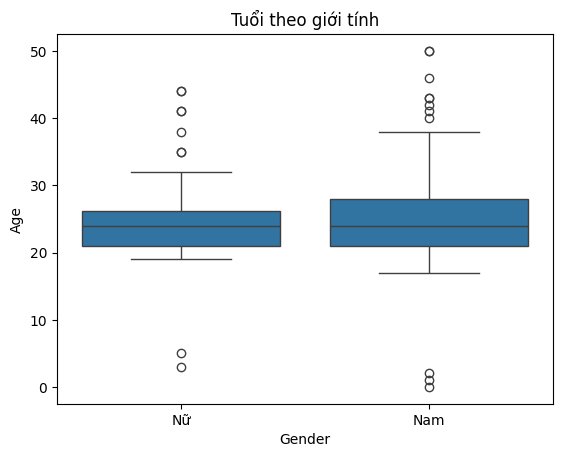

In [77]:
sns.boxplot(x='Gender', y='Age', data=df_customers)
plt.title('Tuổi theo giới tính')
plt.show()


Phân bố khách hàng theo nhóm tuổi:
AgeGroup
18-24       118
25-34        86
35-49        17
Không rõ      9
Dưới 18       6
50-64         2
Name: count, dtype: int64


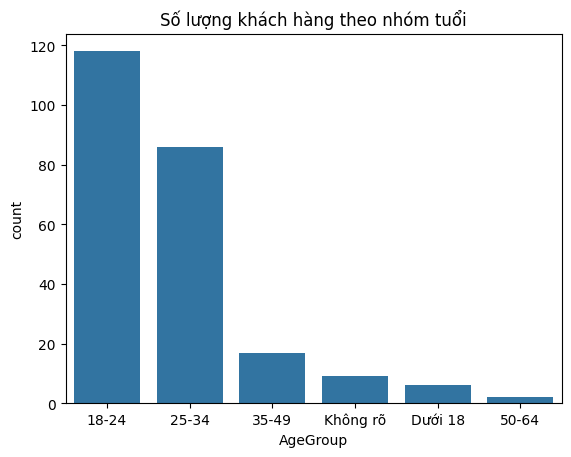

In [78]:
print("Phân bố khách hàng theo nhóm tuổi:")
print(df_customers['AgeGroup'].value_counts())

# Vẽ biểu đồ
sns.countplot(x='AgeGroup', data=df_customers)
plt.title('Số lượng khách hàng theo nhóm tuổi')
plt.show()
